# __06__ `     OBS    `

In [2]:
import os 
import sys
sys.path.append('../dependencies/')
import flopy
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# simulation
sim_name = 'symple_ex06'
exe_name = os.path.join('..','bin', 'mf6.exe')
workspace = os.path.join('..','models','symple_ex06')

sim = flopy.mf6.MFSimulation(sim_name=sim_name, exe_name=exe_name, version="mf6",  sim_ws=workspace)

Change the TDIS perioddata.

In [4]:
perioddata = [(1.0, 1, 1.0), (365, 12, 1.0)] 
nper = len(perioddata)
time_units = 'days'
tdis = flopy.mf6.ModflowTdis(sim, pname="tdis", nper=nper,  perioddata=perioddata,  time_units=time_units)

In [ ]:
# tdis
time_units = 'days'
tdis = flopy.mf6.ModflowTdis(sim, pname="tdis",
                                  nper=nper, 
                                  perioddata=perioddata, 
                                  time_units=time_units)

In [5]:
model_name = 'symp06'
gwf = flopy.mf6.ModflowGwf(sim, modelname=model_name, save_flows=True, print_flows=True)
ims = flopy.mf6.ModflowIms(sim, pname="ims", complexity="SIMPLE",linear_acceleration="BICGSTAB",)
sim.register_ims_package(ims, [gwf.name])

In [8]:
length_units = "METERS"
length_units,  nlay,Lx,Ly,  delr,delc = "METERS",   3,1000,1500,   100,100      # print(f'Cell size:{delr} x {delc}')
top, botm = 50, [40, 35, 0]
ncol, nrow = 100,100            # ______________  int(Lx/delc) 15 , int(Ly/delr)  10
dis = flopy.mf6.ModflowGwfdis(gwf, nlay=nlay, nrow=nrow, ncol=ncol, delr=delr, delc=delc, top=top, botm=botm)

__IC__ + __K__  + __RCH__

In [14]:
strt = np.full((nlay, nrow, ncol), top)
ic = flopy.mf6.ModflowGwfic(gwf, pname="ic", strt=strt)

k, icelltype  = [5, 0.1, 10],  [1, 0, 0]
npf = flopy.mf6.ModflowGwfnpf(gwf, icelltype=icelltype, k=k,  save_flows=True,  save_specific_discharge=True)

recharge = 50/1000/365
rcha = flopy.mf6.ModflowGwfrcha(gwf, pname='rch', recharge=recharge)

wel_spd = {0:[],   1:  [    ((2, 5, 3), -100),    ((2, 10, 6), -50)  ]    }
wel = flopy.mf6.ModflowGwfwel(gwf, stress_period_data=wel_spd, print_input=True, print_flows=True, save_flows=True)

ss, sy  = nlay * [1e-5], nlay * [0.2]          # (sy libre)

sto = flopy.mf6.ModflowGwfsto(gwf, steady_state={0:True},  transient={1:True}, iconvert = [1, 0, 0], ss=ss,  sy=sy, save_flows=True)

In [12]:
headfile = f"{gwf.name}.hds"
head_filerecord = [headfile]

budgetfile = f"{gwf.name}.cbb"
budget_filerecord = [budgetfile]

saverecord = [("HEAD", "ALL"), ("BUDGET", "ALL")]
printrecord = [("HEAD", "LAST")]

oc = flopy.mf6.ModflowGwfoc(gwf,          saverecord=saverecord,  head_filerecord=head_filerecord, 
                            budget_filerecord=budget_filerecord,  printrecord=printrecord)

# **OBS, ...  to a Stress Package**

In [15]:
riv_row = 7
stage = top - 5
rbot = botm[0]
cond = 0.1 * delr*delc/1

riv_spd = []
for col in range(ncol): riv_spd.append(((0, riv_row, col), stage, cond, rbot, 'river_bc'))

riv = flopy.mf6.ModflowGwfriv(gwf, stress_period_data=riv_spd, boundnames=True)

In [18]:
riv_obs = {"riv_obs.csv": [("river", "RIV", "river_bc"), ("riv_7_9", "RIV", (0, 7, 9))],
           "riv_obs2.csv":                              [("riv_7_0", "RIV", (0, 7, 0))]}

riv.obs.initialize(digits=3,  print_input=False, continuous=riv_obs)

In [19]:
hd_obs_list = [ ('h_0_7_4', 'HEAD', (0, 7, 4)),     ('h_2_7_4', 'HEAD', (2, 7, 4)), ]
dd_obs_list = [('dd_0_7_4', 'DRAWDOWN', (0, 7, 4)), ('dd_2_7_4', 'DRAWDOWN', (2, 7, 4)), ]
obs_data = { 'head_obs.csv':hd_obs_list, 'drawdown_obs.csv':dd_obs_list,}
obs_package = flopy.mf6.ModflowUtlobs(gwf,  digits=10,  print_input=False, continuous=obs_data)

In [ ]:
sim.write_simulation()
sim.run_simulation()

In [21]:
print(f'Number of obs packages: {len(gwf.obs)}')

Number of obs packages: 2


In [22]:
gwf.obs[0].output.obs_names

['riv_obs.csv', 'riv_obs2.csv']

In [23]:
gwf.obs[1].output.obs_names

['head_obs.csv', 'drawdown_obs.csv']

In [24]:
riv_obs_csv = gwf.obs[0].output.obs(f='riv_obs.csv')
riv_obs_csv.data                                           # ________________________ 01

rec.array([(  1.        , -13800., -138.), ( 31.41666667, -13700., -135.),
           ( 61.83333333, -13600., -133.), ( 92.25      , -13600., -131.),
           (122.66666667, -13600., -130.), (153.08333333, -13600., -129.),
           (183.5       , -13500., -128.), (213.91666667, -13500., -127.),
           (244.33333333, -13500., -126.), (274.75      , -13500., -125.),
           (305.16666667, -13500., -125.), (335.58333333, -13500., -124.),
           (366.        , -13400., -124.)],
          dtype=[('totim', '<f8'), ('RIVER', '<f8'), ('RIV_7_9', '<f8')])

# __PANDAS__

In [26]:
import pandas  as pd
obs_df = pd.DataFrame(riv_obs_csv.data)
obs_df.head()                                               # ________________________ 01

,totim,RIVER,RIV_7_9
0,1.000000,-13800.0,-138.0
1,31.416667,-13700.0,-135.0
2,61.833333,-13600.0,-133.0
3,92.250000,-13600.0,-131.0
4,122.666667,-13600.0,-130.0


<Axes: xlabel='totim'>

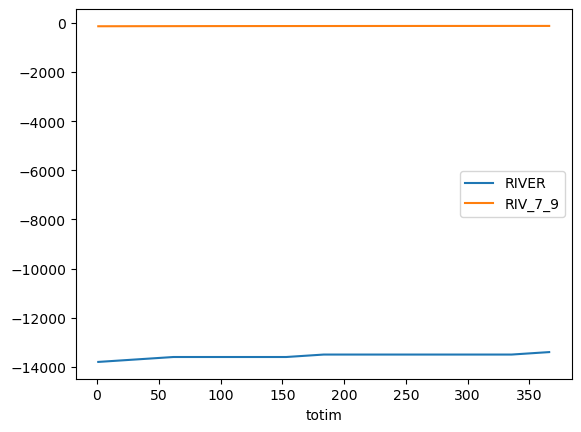

In [27]:
obs_df.plot(x='totim') 